# 13wk-1: 순환신경망 (4)

최규빈  
2024-05-27

# 1. 강의영상

# 2. Import

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
soft = torch.nn.Softmax(dim=1)
sig = torch.nn.Sigmoid()
tanh = torch.nn.Tanh()

# 3. Data – `abcabC`

In [354]:
txt = list('abcabC')*50
txt[:10]

In [355]:
df_train = pd.DataFrame({'x':txt[:-1], 'y':txt[1:]})
df_train[:5]

In [356]:
x = torch.tensor(df_train.x.map({'a':0,'b':1,'c':2,'C':3}))
y = torch.tensor(df_train.y.map({'a':0,'b':1,'c':2,'C':3}))
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

# 4. LSTM의 계산과정 재현

## A. `torch.nn.LSTMCell`

In [591]:
torch.manual_seed(43052) 
lstmcell = torch.nn.LSTMCell(4,2) 
cook = torch.nn.Linear(2,4)
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(lstmcell.parameters())+list(cook.parameters()),lr=0.1)

In [592]:
T = len(x) 
for epoc in range(1):
    ht = torch.zeros(2)
    ct = torch.zeros(2)
    loss = 0 
    ## 1~2
    for t in range(L):
        Xt,yt = X[t], y[t]
        ht,ct = lstmcell(Xt,(ht,ct))
        ot = cook(ht) 
        loss = loss + loss_fn(ot,yt)
    loss = loss / T
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [593]:
ht,ct 

## B. 직접구현

### ***t=0 $\to$ t=1***

`-` lstm_cell 을 이용한 계산 (결과비교용)

In [594]:
torch.manual_seed(43052) 
lstmcell = torch.nn.LSTMCell(4,2) 
cook = torch.nn.Linear(2,4)
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(lstmcell.parameters())+list(cook.parameters()),lr=0.1)

In [595]:
L = len(x) 
for epoc in range(1):
    ht = torch.zeros(2)
    ct = torch.zeros(2)
    loss = 0 
    ## 1~2
    for t in range(1):
        Xt,yt = X[t], y[t]
        ht,ct = lstmcell(Xt,(ht,ct))
        ot = cook(ht) 
        loss = loss + loss_fn(ot,yt)
    loss = loss / T
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [596]:
ht,ct 

-   이런결과를 어떻게 만드는걸까?
-   <https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html>

`-` 직접계산

In [597]:
ht = torch.zeros(2)
ct = torch.zeros(2)

In [598]:
ifgo = Xt @ lstmcell.weight_ih.T + ht @ lstmcell.weight_hh.T + lstmcell.bias_ih + lstmcell.bias_hh

In [599]:
ifgo

In [600]:
input_gate = sig(ifgo[0:2])
forget_gate = sig(ifgo[2:4])
gt = tanh(ifgo[4:6])
output_gate = sig(ifgo[6:8])

In [601]:
ct = forget_gate * ct + input_gate * gt
ht = output_gate * tanh(ct)

In [602]:
ht,ct

### ***t=0 $\to$ t=T***

In [603]:
torch.manual_seed(43052) 
lstmcell = torch.nn.LSTMCell(4,2) 
cook = torch.nn.Linear(2,4)
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(lstmcell.parameters())+list(cook.parameters()),lr=0.1)

In [604]:
L = len(X) 
for epoc in range(1):
    ht = torch.zeros(2)
    ct = torch.zeros(2)
    loss = 0 
    ## 1~2
    for t in range(L):
        Xt,yt = X[t], y[t]
        #--#
        ## lstm_cell step1: calculate ifgo 
        ifgo = Xt @ lstmcell.weight_ih.T + ht @ lstmcell.weight_hh.T + lstmcell.bias_ih + lstmcell.bias_hh
        ## lstm_cell step2: decompose ifgo 
        input_gate = sig(ifgo[0:2])
        forget_gate = sig(ifgo[2:4])
        gt = tanh(ifgo[4:6])
        output_gate = sig(ifgo[6:8])
        ## lstm_cell step3: calculate ht,ct 
        ct = forget_gate * ct + input_gate * gt
        ht = output_gate * tanh(ct)
        #--#    
        ot = cook(ht) 
        loss = loss + loss_fn(ot,yt)
    loss = loss / T
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [605]:
ht,ct

In [ ]:
(tensor([0.0533, 0.2075], grad_fn=<SqueezeBackward1>),
 tensor([0.1218, 0.5590], grad_fn=<SqueezeBackward1>))

## C. epoch ver3 (with torch.nn.LSTM)

In [606]:
torch.manual_seed(43052) 
lstmcell = torch.nn.LSTMCell(4,2)
cook = torch.nn.Linear(2,4) 

In [607]:
lstm = torch.nn.LSTM(4,2) 

In [608]:
lstm.weight_hh_l0.data = lstmcell.weight_hh.data 
lstm.bias_hh_l0.data = lstmcell.bias_hh.data 
lstm.weight_ih_l0.data = lstmcell.weight_ih.data 
lstm.bias_ih_l0.data = lstmcell.bias_ih.data 

In [391]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(lstm.parameters()) + list(cook.parameters()), lr=0.1) 

In [610]:
Water = torch.zeros(1,2) 
for epoc in range(1): 
    ## step1 
    h, (ht,ct) = lstm(X,(Water,Water))
    netout = cook(h)
    ## step2
    loss = loss_fn(netout,y) 
    ## step3
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad() 

In [611]:
ht,ct

# 5. LSTM은 왜 강한가?

## A. 적합 및 시각화

`-` 적합

In [526]:
torch.manual_seed(0)
lstm = torch.nn.LSTM(4,2)
cook = torch.nn.Linear(2,4)

In [527]:
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(lstm.parameters())+ list(cook.parameters()),lr=0.1)

In [528]:
Water = torch.zeros(1,2) 
for epoc in range(200): 
    ## step1 
    h, (ht,ct) = lstm(X,(Water,Water))
    netout = cook(h)
    ## step2
    loss = loss_fn(netout,y) 
    ## step3
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad() 

`-` 시각화

In [529]:
L = len(x)
input_gate = torch.zeros(L,2)
forget_gate = torch.zeros(L,2)
output_gate = torch.zeros(L,2)
g = torch.zeros(L,2)
cell = torch.zeros(L,2)
h = torch.zeros(L,2) 

In [540]:
# 중간에 숨겨진 층들을 시각화 하기 위한 도구
## t=0
water = torch.zeros(2)
ifgo = X[0] @ lstm.weight_ih_l0.T + water @ lstm.weight_hh_l0.T + lstm.bias_ih_l0 + lstm.bias_hh_l0 
input_gate[0] = sig(ifgo[0:2])
forget_gate[0] = sig(ifgo[2:4])
g[0] = tanh(ifgo[4:6])
output_gate[0] = sig(ifgo[6:8])
cell[0] = forget_gate[0] * water + input_gate[0] * g[0]
h[0] = output_gate[0] * tanh(cell[0])
## t>0 
for t in range(1,L): 
    ## 1: calculate _ifgo 
    ifgo = X[t] @ lstm.weight_ih_l0.T + h[t-1] @ lstm.weight_hh_l0.T + lstm.bias_ih_l0 + lstm.bias_hh_l0 
    ## 2: decompose _ifgo 
    input_gate[t] = sig(ifgo[0:2])
    forget_gate[t] = sig(ifgo[2:4])
    g[t] = tanh(ifgo[4:6])
    output_gate[t] = sig(ifgo[6:8])
    ## 3: calculate ht,ct 
    cell[t] = forget_gate[t] * cell[t-1] + input_gate[t] * g[t]
    h[t] = output_gate[t] * tanh(cell[t])

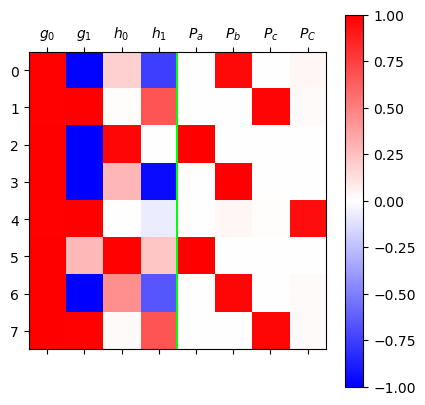

In [547]:
mat = torch.concat([g,h,soft(netout)],axis=1)[:8].data
plt.matshow(mat,cmap='bwr',vmin=-1,vmax=1);
plt.axvline(x=3.5,color="lime")
plt.xticks(
    ticks=range(mat.shape[-1]),
    labels=[r"$g_0$",r"$g_1$",r"$h_0$",r"$h_1$",
            r"$P_a$",r"$P_b$",r"$P_c$",r"$P_C$"]
)
plt.colorbar()

## B. 시각화1: $({\boldsymbol g}_t, {\boldsymbol c}_{t-1}) \to {\boldsymbol c}_{t}$

In [542]:
mat1 = torch.concat([g[1:9],input_gate[1:9],g[1:9]*input_gate[1:9]],axis=1).data
mat2 = torch.concat([cell[:8],forget_gate[1:9],cell[:8]*forget_gate[1:9]],axis=1).data
mat3 = torch.concat([g[1:9]*input_gate[1:9],cell[:8]*forget_gate[1:9],cell[1:9]],axis=1).data

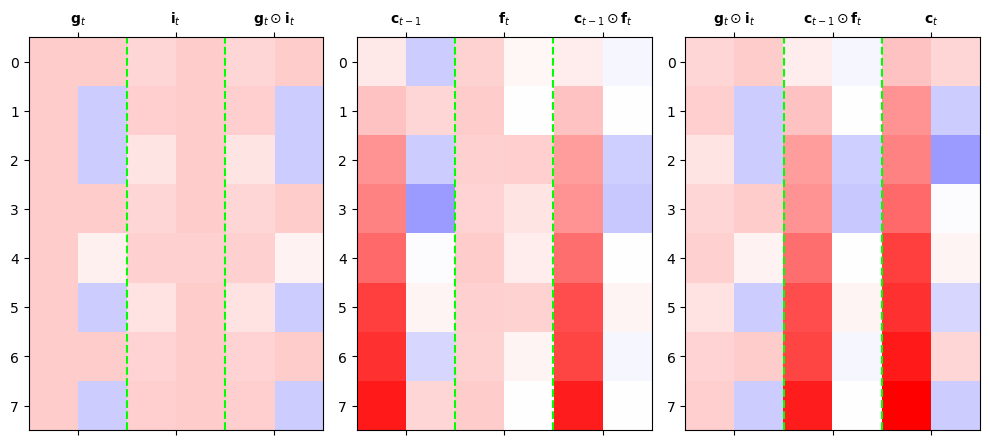

In [543]:
fig,ax = plt.subplots(1,3,figsize=(10,10))
ax[0].matshow(mat1,cmap='bwr',vmin=-5,vmax=5);
ax[0].axvline(x=1.5,linestyle="dashed",color="lime")
ax[0].axvline(x=3.5,linestyle="dashed",color="lime")
ax[0].set_xticks(ticks= [0.5,2.5,4.5],labels=[r'${\bf g}_t$',r'${\bf i}_t$',r'${\bf g}_t \odot {\bf i}_t$']);
ax[1].matshow(mat2,cmap='bwr',vmin=-5,vmax=5);
ax[1].axvline(x=1.5,linestyle="dashed",color="lime")
ax[1].axvline(x=3.5,linestyle="dashed",color="lime")
ax[1].set_xticks(ticks= [0.5,2.5,4.5],labels=[r'${\bf c}_{t-1}$',r'${\bf f}_t$',r'${\bf c}_{t-1} \odot {\bf f}_t$']);
ax[2].matshow(mat3,cmap='bwr',vmin=-5,vmax=5);
ax[2].axvline(x=1.5,linestyle="dashed",color="lime")
ax[2].axvline(x=3.5,linestyle="dashed",color="lime")
ax[2].set_xticks(ticks= [0.5,2.5,4.5],labels=[r'${\bf g}_t \odot {\bf i}_t$',r'${\bf c}_{t-1} \odot {\bf f}_t$',r'${\bf c}_t$']);
fig.tight_layout()

`-` ${\boldsymbol g}_t$ 특징: 보통 -1,1 중 하나의 값을 가지도록 학습되어
있다. (마치 RNN의 hidden node처럼!)

-   $\boldsymbol{g}_t = \tanh({\boldsymbol x}_t {\bf W}_{ig} + {\boldsymbol h}_{t-1} {\bf W}_{hg}+ {\boldsymbol b}_{ig}+{\boldsymbol b}_{hg})$

`-` ${\boldsymbol c}_t$ 특징: ${\boldsymbol g}_t$와 매우 비슷하지만 약간
다른값을 가진다. 그래서 ${\boldsymbol g}_t$와는 달리 -1,1 이외의 값도
종종 등장.

## C. 시각화2: ${\boldsymbol g}_t \to {\boldsymbol h}_{t}$

In [549]:
mat = torch.concat([g[:8],cell[:8],output_gate[:8],cell[:8]*output_gate[:8],h[:8]],axis=1).data

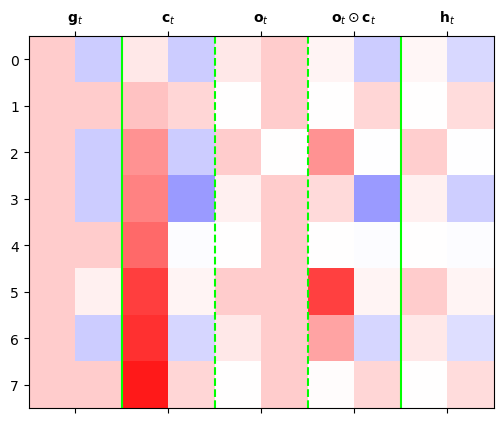

In [556]:
plt.matshow(mat.data,cmap='bwr',vmin=-5,vmax=5)
plt.xticks([0.5,2.5,4.5,6.5,8.5],[r'${\bf g}_t$',r'${\bf c}_t$',r'${\bf o}_t$',r'${\bf o}_t \odot {\bf c}_t$',r'${\bf h}_t$']);
plt.axvline(x=1.5,color="lime")
plt.axvline(x=3.5,linestyle="dashed",color="lime")
plt.axvline(x=5.5,linestyle="dashed",color="lime")
plt.axvline(x=7.5,color="lime")

`-` ${\boldsymbol h}_t$ 특징: (1) ${\boldsymbol c}_t$에서 원하는 것만
선택적으로 특징으로 삼은 느낌. (2) $c_t$보다 훨씬 값을 다양하게 가진다.
($\odot$ 의 효과 )

## D. LSTM의 알고리즘 리뷰 I (수식위주)

**(step1)** calculate ${\tt ifgo}$

${\tt ifgo} = {\boldsymbol x}_t \big[{\bf W}_{ii} | {\bf W}_{if}| {\bf W}_{ig} |{\bf W}_{io}\big] + {\boldsymbol h}_{t-1} \big[ {\bf W}_{hi}|{\bf W}_{hf} |{\bf W}_{hg} | {\bf W}_{ho} \big] + bias$

$=\big[{\boldsymbol x}_t{\bf W}_{ii} + {\boldsymbol h}_{t-1}{\bf W}_{hi} ~\big|~ {\boldsymbol x}_t{\bf W}_{if}+ {\boldsymbol h}_{t-1}{\bf W}_{hf}~ \big|~ {\boldsymbol x}_t{\bf W}_{ig} + {\boldsymbol h}_{t-1}{\bf W}_{hg} ~\big|~ {\boldsymbol x}_t{\bf W}_{io} + {\boldsymbol h}_{t-1}{\bf W}_{ho} \big] + bias$

참고: 위의 수식은 아래코드에 해당하는 부분

``` python
ifgo = xt @ lstm_cell.weight_ih.T +\
       ht @ lstm_cell.weight_hh.T +\
       lstm_cell.bias_ih + lstm_cell.bias_hh
```

**(step2)** decompose ${\tt ifgo}$ and get ${\boldsymbol i}_t$,
${\boldsymbol f}_t$, ${\boldsymbol g}_t$, ${\boldsymbol o}_t$

${\boldsymbol i}_t = \sigma({\boldsymbol x}_t {\bf W}_{ii} + {\boldsymbol h}_{t-1} {\bf W}_{hi} +bias )$

${\boldsymbol f}_t = \sigma({\boldsymbol x}_t {\bf W}_{if} + {\boldsymbol h}_{t-1} {\bf W}_{hf} +bias )$

${\boldsymbol g}_t = \tanh({\boldsymbol x}_t {\bf W}_{ig} + {\boldsymbol h}_{t-1} {\bf W}_{hg} +bias )$

${\boldsymbol o}_t = \sigma({\boldsymbol x}_t {\bf W}_{io} + {\boldsymbol h}_{t-1} {\bf W}_{ho} +bias )$

**(step3)** calculate ${\boldsymbol c}_t$ and ${\boldsymbol h}_t$

${\boldsymbol c}_t = {\boldsymbol i}_t \odot {\boldsymbol g}_t+ {\boldsymbol f}_t \odot {\boldsymbol c}_{t-1}$

${\boldsymbol h}_t = \tanh({\boldsymbol o}_t \odot {\boldsymbol c}_t)$

## E. LSTM의 알고리즘 리뷰 II (느낌위주)

-   이해 및 암기를 돕기위해서 비유적으로 설명한 챕터입니다..

`-` 느낌: RNN이 콩물에서 간장을 한번에 숙성시키는 방법이라면 LSTM은
콩물에서 간장을 단계를 나누어 숙성하는 느낌이다.

-   RNN:
    ${\boldsymbol x}_t \overset{{\boldsymbol h}_{t-1}}{\longrightarrow} {\boldsymbol h}_t$
-   LSTM:
    ${\boldsymbol x}_t \overset{{\boldsymbol h}_{t-1}}{\longrightarrow} {\boldsymbol g}_t \overset{{\boldsymbol c}_{t-1}}{\longrightarrow} \Big({\boldsymbol c}_t \to {\boldsymbol h}_t \Big)$

`-` ${\boldsymbol g}_t$에 대하여

-   과거와 현재의 결합 (선형변환): ${\boldsymbol x}_t$와
    ${\boldsymbol h}_{t-1}$를 ${\bf W}_{ig}, {\bf W}_{hg}$를 이용해
    선형결합
-   숙성(비선형변환): $\tanh$
-   느낌: RNN에서 간장을 만들던 그 수식에서 $h_t$를 $g_t$로 바꾼것
    그래서 RNN의 간장과 비슷하다고 생각하면 된다.
-   노트: RNN의 간장은 한계를 가지고 있는데 그 한계를 극복하기 위해 만든
    것이 ${\boldsymbol c}_t$

`-` ${\boldsymbol c}_t$에 대하여

-   과거와 현재의 결합 (선형변환): ${\boldsymbol g}_{t}$와
    ${\boldsymbol c}_{t-1}$를 요소별로 선택하고 더하는 과정
-   숙성 (비선형변환): 없음.
-   느낌: 과거와 현재의 정보중 유리한것만 기억하여 선택적으로 결합함.
    이때 결합방식에 대한 노하우는 ${\tt input-gate}$,
    ${\tt forget-gate}$ 에 있으며 그러한 결합의 결과가
    ${\boldsymbol c}_t$에 있음. 이 ${\boldsymbol c}_t$에 대한 정보는
    그대로 “냉동보관(?)”되어 다음세대로 내려옴.
-   비고: ${\boldsymbol c}_t$는 사실상 LSTM 알고리즘의 꽃이라 할 수
    있음. LSTM은 long short term memory의 약자임. 기존의 RNN은
    장기기억을 활용함에 약점이 있는데 LSTM은 단기기억/장기기억 모두 잘
    활용함. LSTM이 장기기억을 잘 활용하는 비법은 바로
    ${\boldsymbol c}_t$에 있다.

`-` ${\boldsymbol h}_t$에 대하여

-   과거와 현재의 결합 (선형변환): 없음
-   숙성 (비선형변환): $\tanh({\boldsymbol c}_t)$를 요소별로 선택하여
    숙성

> RNN은 기억할 과거정보가 ${\boldsymbol h}_{t-1}$ 하나이지만 LSTM은
> ${\boldsymbol c}_{t-1}$, ${\boldsymbol h}_{t-1}$ 2개이다.

## F. LSTM이 강한이유

`-` 답변1: LSTM이 장기기억에 유리함. 그 이유는 input, forget, output
gate 들이 장기기억을 위한 역할을 하기 때문.

-   비판: 아키텍처에 대한 이론적 근거는 없음. 장기기억을 위하여 꼭
    LSTM같은 구조일 필요는 없음. (게이트는 꼭3개이어야 하는지?)

`-` 답변2: 아키텍처상으로 LSTM은 RNN을 포함함. 그래서 이론적으로 LSTM의
성능이 RNN보다 떨어질 이유는 없음.

`-` 답변3: 저는 사실 아까 살펴본 아래의 이유로 이해하고 있습니다.

-   실험적으로 살펴보니 LSTM이 RNN보다 장기기억에 유리했음.
-   그 이유: RNN은 ${\boldsymbol h}_t$의 값이 -1 혹은 1로 결정되는
    경우가 많았음. 그러나 경우에 따라서는 ${\boldsymbol h}_t$이 -1~1의
    값을 가지는 것이 문맥적 뉘앙스를 포착하기에는 유리한데 LSTM이 이러한
    방식으로 학습되는 경우가 많았음.
-   왜 LSTM의 ${\boldsymbol h}_t$은 -1,1 이외의 값을 쉽게 가질 수
    있는가? $\odot$ 때문에.. 즉 게이트때문에..

# 6. Ref

`-` 참고자료들

-   <https://colah.github.io/posts/2015-08-Understanding-LSTMs/>
-   <https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html>
-   <https://arxiv.org/abs/1402.1128>